In [3]:
import pandas as pd
import numpy as np
import os
import time
import tensorflow as tf
import tensorflow_hub as hub
import zipfile
from html2text import HTML2Text
from tqdm import tqdm
import re
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

### Set global Parameters
Set your parameters here:         
data_path: In this path put the data you have downloaded with YouTube Data Tools.          
output_path: Tghe files generated in this notebook will be saved here.          
url_dict: URLs to models on Tensorflow hub are saved here. Other models are available there.        
model_type: Define which model you would like to use. Choose one from url_dict           
new_embeddings: If this is true, new embeddings will be generated and saved at output_path. Otherwise, embeddings are loaded from Disc.

In [5]:
data_path = './data/videoinfo_xnudgOC9D5Y_2020_11_24-21_12_03_comments.tab'
output_path = "./output/"

new_embeddings = True

url_dict = {
            'Transformer' : "https://tfhub.dev/google/universal-sentence-encoder-large/5",
            'DAN' : "https://tfhub.dev/google/universal-sentence-encoder/4",
            'Transformer_Multilingual': "https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3"
}

model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

In [7]:
try:
    os.mkdir(output_path)
except OSError:
    print ("Creation of the directory %s failed" % output_path)
else:
    print ("Successfully created the directory %s " % output_path)

Creation of the directory ./output/ failed


In [12]:
if new_embeddings:
    data = pd.read_csv(data_path,sep='\t',header=(0))
    data.head()

In [13]:
if new_embeddings:
    data = data.dropna(subset=['text', 'authorName']) # drop rows with no content
    data=data.drop(['id', 'replyCount','likeCount','authorChannelUrl','authorChannelId','isReplyTo','isReplyToName'],axis=1) # drop unused columns
data.head()

,publishedAt,authorName,text,isReply
0,2020-10-01 07:26:15,Deian Louis Francis A V N G Mountbatten,Every Chinese wants his refrigerator.,0
1,2020-09-27 08:59:13,Inglam,Is the US doing enough to fight climate change? | DW News,0
2,2020-03-28 12:16:56,Roh Nage,"Very funny, China knew very well to create the virus and treat it too. It contained the virus only in Wuhan, which was the hub of many lucrative businesses- so much so, the other part China is continuing to eat creatures and disturb the food chain and natural bio diversity. <br /><br />What China needs to know is that every generation is a custodian of Mother Earth, because none of us created it. We have to hand it over to the next generation intact, and not pollute it the way China has irresponsibly done and finally making all in China to wear masks like robbers! <br />Money is something, but not everything. Greedy China probably has lost a lot of friends, on its way to become ‘super rich’. The irony is, the Chinese people don’t approve the acts of the government. The victimized doctor who died of corona virus is ample evidence to show how people are under pressure! What a shame!",0
3,2020-03-15 20:42:17,literatureclub kidokido,"Whatever Chinese say here, its true that they pollute the most in this world",0
4,2020-03-08 08:11:20,Betty,"So everyone, including the news and the comments are trying to highlight how one nation is doing more than the other. But the main point is, blaming each other is not going to stop anything FIND A WAY TO COOPERATE AND GET SOME WORK DONE stop saying &quot;it&#39;s your fault&quot; please I truly appreciate what Germany and China are working on but all have to work harder",0


In [14]:
if new_embeddings:
    # Remove HTML tags
    tqdm.pandas()
    h = HTML2Text()
    h.ignore_links = True
    data['cleaned'] = data['text'].progress_apply(lambda x: h.handle(x))
    print( "Removed HTML Tags.")

    # Remove links
    http_link_pattern = r'http\S+'
    bitly_link_pattern = r'bit.ly/\S+'
    data['cleaned'] = data['cleaned'].str.replace(http_link_pattern, '')
    data['cleaned'] = data['cleaned'].str.replace(bitly_link_pattern, '')
    print( "Removed Links.")

    # Remove user names
    keep_names = ["earth", "Tide", "Geologist", "A Person", "Titanic", "adventure", "Sun", "The United States Of America"] # user names we want to keep
    user_names = [name for name in data['authorName'].unique() if (len(name)> 3 and name not in keep_names)]
    data['cleaned'] = data['cleaned'].str.replace('|'.join(map(re.escape, user_names)), '')
    print( "Removed user names.")

100%|██████████| 185/185 [00:00<00:00, 2554.05it/s]

Removed HTML Tags.
Removed Links.
Removed user names.


In [19]:
if new_embeddings:
    data.to_pickle(output_path+'data_preprocessed'+'.pkl')
else:
    data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
data.head()

,publishedAt,authorName,text,isReply,cleaned
0,2020-10-01 07:26:15,Deian Louis Francis A V N G Mountbatten,Every Chinese wants his refrigerator.,0,Every Chinese wants his refrigerator.\n\n
1,2020-09-27 08:59:13,Inglam,Is the US doing enough to fight climate change? | DW News,0,Is the US doing enough to fight climate change? | DW News\n\n
2,2020-03-28 12:16:56,Roh Nage,"Very funny, China knew very well to create the virus and treat it too. It contained the virus only in Wuhan, which was the hub of many lucrative businesses- so much so, the other part China is continuing to eat creatures and disturb the food chain and natural bio diversity. <br /><br />What China needs to know is that every generation is a custodian of Mother Earth, because none of us created it. We have to hand it over to the next generation intact, and not pollute it the way China has irresponsibly done and finally making all in China to wear masks like robbers! <br />Money is something, but not everything. Greedy China probably has lost a lot of friends, on its way to become ‘super rich’. The irony is, the Chinese people don’t approve the acts of the government. The victimized doctor who died of corona virus is ample evidence to show how people are under pressure! What a shame!",0,"Very funny, China knew very well to create the virus and treat it too. It\ncontained the virus only in Wuhan, which was the hub of many lucrative\nbusinesses- so much so, the other part China is continuing to eat creatures\nand disturb the food chain and natural bio diversity. \n \nWhat China needs to know is that every generation is a custodian of Mother\nEarth, because none of us created it. We have to hand it over to the next\ngeneration intact, and not pollute it the way China has irresponsibly done and\nfinally making all in China to wear masks like robbers! \nMoney is something, but not everything. Greedy China probably has lost a lot\nof friends, on its way to become ‘super rich’. The irony is, the Chinese\npeople don’t approve the acts of the government. The victimized doctor who\ndied of corona virus is ample evidence to show how people are under pressure!\nWhat a shame!\n\n"
3,2020-03-15 20:42:17,literatureclub kidokido,"Whatever Chinese say here, its true that they pollute the most in this world",0,"Whatever Chinese say here, its true that they pollute the most in this world\n\n"
4,2020-03-08 08:11:20,Betty,"So everyone, including the news and the comments are trying to highlight how one nation is doing more than the other. But the main point is, blaming each other is not going to stop anything FIND A WAY TO COOPERATE AND GET SOME WORK DONE stop saying &quot;it&#39;s your fault&quot; please I truly appreciate what Germany and China are working on but all have to work harder",0,"So everyone, including the news and the comments are trying to highlight how\none nation is doing more than the other. But the main point is, blaming each\nother is not going to stop anything FIND A WAY TO COOPERATE AND GET SOME WORK\nDONE stop saying ""it's your fault"" please I truly appreciate what Germany and\nChina are working on but all have to work harder\n\n"


In [20]:
hub_url = url_dict[model_type]
if new_embeddings:
    print("Loading model. This will take some time...")
    embed = hub.load(hub_url)

Loading model. This will take some time...


In [21]:
# Produce embeddings of your documents.
if new_embeddings:
    for k,g in data.groupby(np.arange(len(data))//200):
        if k == 0:
            embeddings = embed(g['cleaned'])
        else:
            embeddings_new = embed(g['cleaned'])
            embeddings = tf.concat(values=[embeddings,embeddings_new],axis = 0)
            print(k , end =" ")
    print("The embeddings vector is of fixed length {}".format(embeddings.shape[1]))

    np.save(output_path+'/embeddings'+model_type+'.npy', embeddings, allow_pickle=True, fix_imports=True)
else:
    embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

embeddings.shape

The embeddings vector is of fixed length 512


TensorShape([185, 512])

### Calculate Similarity Matrix with angular distance
'Following Cer et al. (2018), we first compute the sentence embeddings u, v for an STS sentence pair, and then score the sentence pair similarity based on the angular distance between the two embedding vectors d = − arccos (uv/||u|| ||v||).'

In [22]:
from sklearn.metrics.pairwise import cosine_similarity
def cos_sim(input_vectors):
    similarity = cosine_similarity(input_vectors)
    return similarity
cosine_similarity_matrix = cos_sim(np.array(embeddings))
print(cosine_similarity_matrix)

[[1.         0.05430152 0.2601952  ... 0.16105841 0.25901526 0.05802713]
 [0.05430152 1.         0.05508678 ... 0.07702021 0.03073265 0.1148859 ]
 [0.2601952  0.05508678 0.9999999  ... 0.15444857 0.2989418  0.11640346]
 ...
 [0.16105841 0.07702021 0.15444857 ... 1.0000001  0.30962092 0.39522982]
 [0.25901526 0.03073265 0.2989418  ... 0.30962092 1.0000001  0.21590552]
 [0.05802713 0.1148859  0.11640346 ... 0.39522982 0.21590552 1.0000002 ]]


In [26]:
np.shape(cosine_similarity_matrix)

(185, 185)

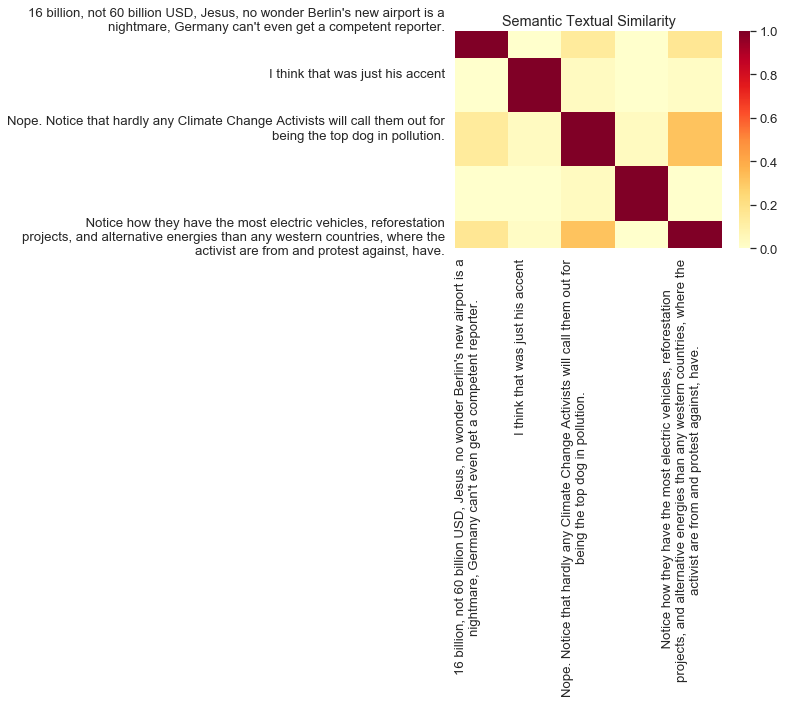

In [29]:
import seaborn as sns
def plot_similarity(labels, features, rotation):
    corr = np.inner(features, features)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")

num_samples = 5
off_set = 100

plot_similarity(data.iloc[off_set:off_set+num_samples]['cleaned'], embeddings[off_set:off_set+num_samples], 90)

In [32]:
# Define which comment to analyze
comment_index = 3
comment = data["cleaned"][comment_index]
comment_list = data["cleaned"].tolist()
print(comment)

Whatever Chinese say here, its true that they pollute the most in this world




In [33]:
# Print similar comments.
def get_top_similar(sentence, sentence_list, similarity_matrix, topN):
    # find the index of sentence in list
    index = sentence_list.index(sentence)
    # get the corresponding row in similarity matrix
    similarity_row = np.array(similarity_matrix[index, :])
    # get the indices of top similar
    indices = similarity_row.argsort()[-topN:][::-1]
    return [sentence_list[i] for i in indices]


for i, value in enumerate(get_top_similar(comment, comment_list, cosine_similarity_matrix, 20)):
    print("Top similar comment {}: {}".format(i+1, value))

Top similar comment 1: Whatever Chinese say here, its true that they pollute the most in this world


Top similar comment 2: Well, a lot of pollution the PRC produces stays in the PRC, so the Chinese
people there suffer the most. Most protests in the PRC (which the state media
does not report on) are against some pollution or another. Indeed, one bad day
when many people die due to pollution might just be the start of CCP's fall.


Top similar comment 3: I just returned from Peking, China. I see at least a huge use of electrical
vehicles. So, the question is if there is as much carbon emissions per
capita....


Top similar comment 4: I am not a Chinese ......but this is bull shit news....more people fly in
Western countries than in China....blame everything for China ...hurray....how
fast they are changing source of energy from coal to solar ..check the stat.no
country has done with this speed.......and industrial revolution started in
Western countries at late 19th century when asian 